<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/14_rl/00_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q学習（Q-Learning）


---

必要なモジュール

In [ ]:
!apt-get -qq -y install libcusparse9.1 libnvrtc9.1 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.9.1 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null

!pip -q install gym
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay

必要なライブラリ

In [ ]:
import numpy as np
import gym
import gym.spaces

import time
import math
import random
import cv2
import matplotlib
import matplotlib.pyplot as plt
import collections
from itertools import count
from PIL import Image
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# 使用するデバイス（GPU or CPU）の決定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Use device:", device)

Use device: cuda


# Q-Learning (Q-table)
Q-Learningとは、強化学習の手法の中で、TD法を用いた代表的な手法の一つです。最適な行動価値(Q値)を推定するように学習を行いQ値を行動の指針として用いることで最適な行動を行います。Q学習では，全ての状態$s$と行動$a$に対する価値$Q(s, a)$を記録するテーブル(Q-table) を作成します。しかし、初期段階では、各状態と行動に対する正確な行動価値がわからないため、Q-tableを任意の値に初期化します。その後、あらゆる状態の下で行動を行い推定した行動価値を用いてQ-tableを修正していきます。以下に簡略化したQ-Learningの学習方法を記載します。
1. ある環境における全ての状態と行動に対する価値(Q値)を記録するためのQ-tableを作成
2. Q-tableに記録されたQ値を任意の値で初期化
3. $\epsilon$-greedy法などを用いて環境に対する行動を選択
4. 行った行動に対する報酬値とQ-tableに記録されたQ値をもとにQ-tableを更新
5. 最適なQ-tableが完成するまで3,4を繰り返す

## 環境の作成
今回の実験で使用する環境の作成を行います。 [OpenAI Gym](https://github.com/openai/gym) は、様々な種類の環境を提供しているモジュールです。
 
今回の実験ではgymで利用できるCartPoleを実行します。
まず、gym.make関数で実行したい環境を指定します。
その後、reset関数を実行することで、環境を初期化します。また、環境に対する情報を表示することもできます。\
CartPoleは、Cartを操作し、Cartに乗ったPoleを倒さないようにするという環境です。環境における行動は右と左に動くという離散的な行動をもち、状態は連続的な値であらわされたCart位置、Cart速度、Poleの角度、Poleの角速度からなる状態をもっています。

In [ ]:
env = gym.make('CartPole-v0')

obs = env.reset()
print('observation space:',env.observation_space)
print('action space:',env.action_space)
print('initial observation',obs)

observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: Discrete(2)
initial observation [-0.01054514  0.01209247  0.01266605  0.0453596 ]


## Q-tableの作成、離散化処理
Q-tableの作成とCartPole環境における状態の離散化処理を行います。\
Q-LearningはQ-tableを用いた学習を行います。しかし、今回使用する環境であるCartPoleはCart位置、Cart速度、Poleの角度、Poleの角速度からなる4次元の状態をもっておりCart速度は(-2.4～2.4)、Cart速度は(-3.0～3.0)、Poleの角度は(-0.5, 0.5)、Poleの角速度は(-2.0, 2.0)の範囲で連続的な数値となっています。Q-Learningでは、任意の大きさのQ-tableを作成しなければいけないため、連続的な数値ではQ-tableを作成することができません。なので、状態を分割し離散的な値に変換することでQ-tableを作成可能とします。
今回はnumpyのdigitize関数とlinspace関数を組み合わせて離散化処理を行います。まず、linspace関数で分割数に応じて状態の範囲を区切ります。そして、dizitize関数である値が区切られた範囲でどこの区画に属するのかを返します。これにより、連続的な数値であってもその値がどの区画なのかという数値に変換されるため、離散化された値とすることができます。
状態の分割により環境における状態数が決定されるため決定した状態数の大きさに合わせたQ-tableを作成します。\
初めに決定した状態の分割数$x$により、離散化する際の値が変化し、Q-tableの大きさが変化します。CartPoleは4次元の状態を持っているためQ-tableの大きさは $x^4(状態数)×2(actionの数)$となります。

In [ ]:
num_dizitized = 10  #状態の分割数

def bins(clip_min, clip_max, num):
    return np.linspace(clip_min, clip_max, num + 1)[1:-1]

# 各値を離散値に変換
def digitize_state(observation):
    cart_pos, cart_v, pole_angle, pole_v = observation
    digitized = [
        np.digitize(cart_pos, bins=bins(-2.4, 2.4, num_dizitized)),
        np.digitize(cart_v, bins=bins(-3.0, 3.0, num_dizitized)),
        np.digitize(pole_angle, bins=bins(-0.5, 0.5, num_dizitized)),
        np.digitize(pole_v, bins=bins(-2.0, 2.0, num_dizitized))
    ]
    return sum([x * (num_dizitized**i) for i, x in enumerate(digitized)])

q_table = np.random.uniform(low=-1, high=1, size=(num_dizitized**4, env.action_space.n))

## アクションの選択 ($\epsilon$-greedy法)
アクションの選択方法として$\epsilon$-greedy法を用いた行動選択の定義を行います。\
Q-Learningでは、Q値をもとに行動選択を行いますが、Q値が大きい行動のみをとり続けることは、局所解へ陥ってしまう問題につながります。そこで、環境の適度な探索と学習によって得られた知見を活用した行動(利用)が重要であり、この探索と利用のトレードオフの問題が強化学習における大きな課題となっています。
$\epsilon$-greedy法は、適度な探索を行う手法であり、確率$\epsilon$でQ値が最も大きい行動を選択し、確率$1-\epsilon$で、ランダムな行動を選択するといった手法です。確率$\epsilon$の値は、学習が進むごとに大きくなっていき、学習初期は探索を行い、徐々に最適な行動のみを選択するようになります。

In [ ]:
def get_action_q(next_state, episode):
    #徐々に最適行動のみをとる、ε-greedy法
    epsilon = 0.5 * (1 / (episode + 1))
    if epsilon <= np.random.uniform(0, 1):
        next_action = np.argmax(q_table[next_state])
    else:
        next_action = np.random.choice([0, 1])
    return next_action

## Qテーブルの更新
Q-tableの更新関数を定義します。\
Q-Learningは、報酬と行動価値をもとに最適なQ-tableを推定していく手法であり、Q-tableの更新にはTD法を用いた更新を行います。ある状態におけるある行動の価値を次状態における最良の行動価値に近似するように更新を行っていきます。更新式としては以下の式となり、この更新式を用いて初期化したQ-tableの更新を行っていきます。あらゆる状態を経験することにより最適なQ-tableが作成されます。


\
$$
Q(s,a)←Q(s,a)+\alpha(r+\gamma \max_{a'}Q(s',a')-Q(s,a))
$$

In [ ]:
def update_Qtable(q_table, state, action, reward, next_state):
    gamma = 0.99
    alpha = 0.5
    next_Max_Q=max(q_table[next_state][0],q_table[next_state][1] )
    q_table[state, action] = (1 - alpha) * q_table[state, action] + alpha * (reward + gamma * next_Max_Q)

    return q_table

## 学習に必要な各種パラメータ設定
今回の実験に使用する各種パラメータの設定を行います。ここでは、学習における総試行回数などの学習で必要なパラメータの設定を行っています。

In [ ]:
max_number_of_steps = 200  #1試行のstep数
num_consecutive_iterations = 100  #学習完了評価に使用する平均試行回数
num_episodes = 2000  #総試行回数
total_reward_vec = np.zeros(num_consecutive_iterations)  #各試行の報酬を格納

## Q-Learningメインプログラム
Q-Learningのメイン関数です。ここまでの設定に従いQ-Learningを用いて学習します。以下のような流れのプログラムを作成します．
1. 環境を初期化・離散化し，初期状態を獲得
2. 獲得した初期状態から行動を選択($\epsilon$-greedy法を用いた行動選択)
3. 環境に対してエージェントが行動(遷移情報の獲得)
4. 得られた経験を用いてQ-tableを更新
5. 指定したステップ数分2～4を繰り返す

In [ ]:
for episode in range(num_episodes):  #試行数分繰り返す
    # 環境の初期化
    observation = env.reset()
    state = digitize_state(observation)
    action = np.argmax(q_table[state])
    episode_reward = 0

    for t in range(max_number_of_steps):  #1試行のループ

        # 行動a_tの実行により、s_{t+1}, r_{t}などを計算する
        observation, reward, done, info = env.step(action)

        # 報酬を設定し与える
        if done:
            if t < 195:
                reward = -200  #こけたら罰則
            else:
                reward = 1  #立ったまま終了時は罰則はなし
        else:
            reward = 1  #各ステップで立ってたら報酬追加

        episode_reward += reward  #報酬を追加

        # 離散状態s_{t+1}を求め、Q関数を更新する
        next_state = digitize_state(observation)  #t+1での観測状態を、離散値に変換
        q_table = update_Qtable(q_table, state, action, reward, next_state)

        #  次の行動a_{t+1}を求める 
        action = get_action_q(next_state, episode)    # a_{t+1} 

        state = next_state

        #終了時の処理
        if done and (t%100==0):
            print('%d Episode finished after %f time steps / mean %f' %
                  (episode, t + 1, total_reward_vec.mean()))
            total_reward_vec = np.hstack((total_reward_vec[1:],
                                          episode_reward))  #報酬を記録


[-2.4  -1.92 -1.44 -0.96 -0.48  0.    0.48  0.96  1.44  1.92  2.4 ]
[-1.92 -1.44 -0.96 -0.48  0.    0.48  0.96  1.44  1.92]
[-3.  -2.4 -1.8 -1.2 -0.6  0.   0.6  1.2  1.8  2.4  3. ]
[-2.4 -1.8 -1.2 -0.6  0.   0.6  1.2  1.8  2.4]
[-0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5]
[-0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4]
[-2.  -1.6 -1.2 -0.8 -0.4  0.   0.4  0.8  1.2  1.6  2. ]
[-1.6 -1.2 -0.8 -0.4  0.   0.4  0.8  1.2  1.6]
[-2.4  -1.92 -1.44 -0.96 -0.48  0.    0.48  0.96  1.44  1.92  2.4 ]
[-1.92 -1.44 -0.96 -0.48  0.    0.48  0.96  1.44  1.92]
[-3.  -2.4 -1.8 -1.2 -0.6  0.   0.6  1.2  1.8  2.4  3. ]
[-2.4 -1.8 -1.2 -0.6  0.   0.6  1.2  1.8  2.4]
[-0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5]
[-0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4]
[-2.  -1.6 -1.2 -0.8 -0.4  0.   0.4  0.8  1.2  1.6  2. ]
[-1.6 -1.2 -0.8 -0.4  0.   0.4  0.8  1.2  1.6]
[-2.4  -1.92 -1.44 -0.96 -0.48  0.    0.48  0.96  1.44  1.92  2.4 ]
[-1.92 -1.44 -0.96 -0.48  0.    0.48  0.96  1.44  1.92]
[-3.

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[-1.6 -1.2 -0.8 -0.4  0.   0.4  0.8  1.2  1.6]
[-2.4  -1.92 -1.44 -0.96 -0.48  0.    0.48  0.96  1.44  1.92  2.4 ]
[-1.92 -1.44 -0.96 -0.48  0.    0.48  0.96  1.44  1.92]
[-3.  -2.4 -1.8 -1.2 -0.6  0.   0.6  1.2  1.8  2.4  3. ]
[-2.4 -1.8 -1.2 -0.6  0.   0.6  1.2  1.8  2.4]
[-0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5]
[-0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4]
[-2.  -1.6 -1.2 -0.8 -0.4  0.   0.4  0.8  1.2  1.6  2. ]
[-1.6 -1.2 -0.8 -0.4  0.   0.4  0.8  1.2  1.6]
[-2.4  -1.92 -1.44 -0.96 -0.48  0.    0.48  0.96  1.44  1.92  2.4 ]
[-1.92 -1.44 -0.96 -0.48  0.    0.48  0.96  1.44  1.92]
[-3.  -2.4 -1.8 -1.2 -0.6  0.   0.6  1.2  1.8  2.4  3. ]
[-2.4 -1.8 -1.2 -0.6  0.   0.6  1.2  1.8  2.4]
[-0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5]
[-0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4]
[-2.  -1.6 -1.2 -0.8 -0.4  0.   0.4  0.8  1.2  1.6  2. ]
[-1.6 -1.2 -0.8 -0.4  0.   0.4  0.8  1.2  1.6]
[-2.4  -1.92 -1.44 -0.96 -0.48  0.    0.48  0.96  1.44  1.92  2.4 ]
[-1.92 -1.44 

KeyboardInterrupt: ignored

## 結果を保存
Q-学習を用いて学習したエージェントを確認してみます．\
ここでは，ここでは学習時と同様の処理を行いframesに描画したフレームを順次格納します．学習時と異なるのは，$\epsilon$-greedy法は用いず常にQ値が最も高い行動を選択します．指定したステップ数分フレームを獲得したら終了します．

In [ ]:
# 結果を描画するための設定
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display._obj._screen)


frames = []
for i in range(3):
    done = False
    t = 0
    observation = env.reset() 
    state = digitize_state(observation)
    action = np.argmax(q_table[state])
    episode_reward = 0  
    while not done and t < 200:
        frames.append(env.render(mode='rgb_array'))
        observation, reward, done, info = env.step(action)
        state = digitize_state(observation)
        action = np.argmax(q_table[state])
        t += 1


## 結果を描画
maptlotlibを用いて，保存した動画フレームをアニメーションとして作成し，表示しています．

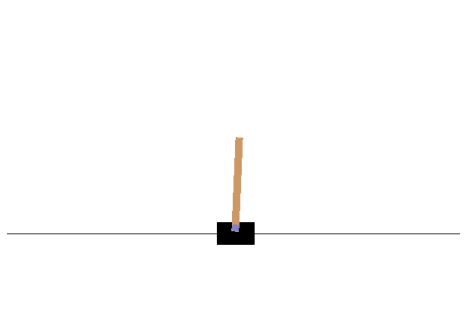

In [ ]:
# 実行結果の表示
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

## 課題

# Q-Network
Q-Networkは、Q-Learningにニューラルネットワークの技術を適用した手法です。\
Q-Learningでは、状態、行動数に合わせたQ-tableを作成し、TD法を用いたQ値の更新を行うことで最適なQ-tableを作成する手法でした。しかし問題点として、CartPoleのような状態数が連続的な値の場合、Q-tableが作成可能となるように状態数の離散化を行わなければいけないという問題点がありました。そこで、Q-Networkではニューラルネットワークを用いた写像関数によって、Q-tableを表現することで、連続的な状態でも直接入力として使用可能としています。ネットワークの出力を各行動に対応するのQ値を出力するように設計し、損失関数を用いた学習により最適なQ関数を近似します。

## 環境の作成
Q-Learningと同様環境の作成を行います。

In [ ]:
env = gym.make('CartPole-v0')

## ネットワークモデル
ネットワークの設計を行います。\
Q-Networkでは、
入力は、CartPoleにおけるCart位置、Cart速度、Poleの角度、Poleの各速度の4次元の情報を直接入力とします。全結合層が2層で構成されるネットワークとし、出力は各行動ごとのQ値を出力するため出力層はactionの数として定義します。

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(QNetwork, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(4, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        return self.fc(x)

## アクション選択
アクションの選択方法として$\epsilon$-greedy法を用いた行動選択の定義を行います。\
Q-Learningと同様に適度な探索を行うため、$\epsilon$-greedy法を用いて行動を選択します。確率$\epsilon$で、ネットワークが出力したQ値の値が最も大きい行動を選択し、確率$1-\epsilon$でランダムな行動を選択します。

In [ ]:
def get_action_qn(next_state, net, episode, device="cpu"):
    epsilon = 0.5 * (1 / (episode + 1))
    if epsilon <= np.random.uniform(0, 1):
        state_a = np.array([next_state], copy=False)
        state_v = torch.tensor(state_a).float().to(device)
        q_vals_v = net(state_v)
        _, act_v = torch.max(q_vals_v, dim=1)
        next_action = int(act_v.item())
    else:
        next_action = np.random.choice([0, 1])

    return next_action

## 損失関数の計算
ネットワークを更新するための損失関数の定義を行います。\
Q-Networkでは、ニューラルネットワークで最適なQ関数を近似します。ニューラルネットワークを用いた学習のため損失関数を設計し、逆伝搬によりネットワークのパラメータを更新していきます。
損失関数はQ-Learnigの更新式をもとに設計されていて、以下のような二乗誤差になっています。

\
$$
L_{\theta}=(r+\gamma \max_{a'}Q_{\theta_{i}}(s',a')-Q_{\theta_{i}}(s,a))^{2}
$$


In [ ]:
def calc_loss(batch, net, device="cpu"):
    states, actions, rewards, dones, next_states = batch

    states_v = torch.tensor(states).float().to(device)
    next_states_v = torch.tensor(next_states).float().to(device)
    actions_v = torch.tensor(actions).to(device)
    rewards_v = torch.tensor(rewards).to(device)
    done_mask = torch.ByteTensor(dones).to(device)

    state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    next_state_values = net(next_states_v).max(1)[0]
    next_state_values[done_mask] = 0.0
    next_state_values = next_state_values.detach()

    expected_state_action_values = next_state_values * GAMMA + rewards_v
    return nn.MSELoss()(state_action_values, expected_state_action_values)

## バッチ処理のためのbuffer
バッチ学習のために経験を収納、取り出す関数を定義します。

In [ ]:
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])

class Buffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in range(batch_size)])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), np.array(next_states)

## 学習に必要な各種パラメータ設定
今回の実験に使用する各種パラメータの設定を行います。ここでは、学習における総試行回数などの学習で必要なパラメータの設定を行っています。
また、ネットワークの定義や、最適化手法を指定しています。今回の実験では最適化手法はAdamとしています。

In [ ]:
max_number_of_steps = 200  #1試行のstep数
num_consecutive_iterations = 100  #学習完了評価に使用する平均試行回数
num_episodes = 2000  #総試行回数

total_reward_vec = np.zeros(num_consecutive_iterations)  #各試行の報酬を格納

LEARNING_RATE = 1e-4 #学習率
GAMMA = 0.99 #割引率

batch_size = 32 #バッチサイズ
device = 'cuda:0'
train_num = 0

net = QNetwork(env.observation_space.shape, env.action_space.n).to(device)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
buffer = Buffer(batch_size)

## 学習のメイン関数
Q-Learningのメイン関数です。ここまでの設定に従いQ-Newtworkの学習を行います。以下のような流れのプログラムを作成します．
1. 環境を初期化・離散化し，初期状態を獲得
2. 獲得した初期状態から行動を選択($\epsilon$-greedy法を用いた行動選択)
3. 環境に対してエージェントが行動(遷移情報の獲得)
4. バッチ数分経験を得たら損失関数の計算
5. 誤差逆伝播法を用いてネットワークの更新
6. 指定したステップ数分2～5を繰り返す

In [ ]:
for episode in range(num_episodes):  #試行数分繰り返す
    # 環境の初期化
    observation = env.reset()
    state = observation
    episode_reward = 0

    for t in range(max_number_of_steps):  #1試行のループ
        action = get_action_qn(observation, net, episode, device)
        # 行動a_tの実行により、s_{t+1}, r_{t}などを計算する
        observation, reward, done, info = env.step(action)
        next_state = observation

        # 報酬を設定し与える
        if done:
            if t < 195:
                reward = -200  #こけたら罰則
            else:
                reward = 1  #立ったまま終了時は罰則はなし
        else:
            reward = 1  #各ステップで立ってたら報酬追加

        episode_reward += reward  #報酬を追加
        
        exp = Experience(state, action, reward, done, next_state)
        buffer.append(exp)
        state = next_state

        if train_num > batch_size:
            optimizer.zero_grad()
            batch = buffer.sample(batch_size)
            loss_t = calc_loss(batch, net, device=device)
            loss_t.backward()
            optimizer.step()
        
        train_num += 1

        #終了時の処理
        if done and (t%100==0):
            print('%d Episode finished after %f time steps / mean %f' %
                  (episode, t + 1, total_reward_vec.mean()))
            total_reward_vec = np.hstack((total_reward_vec[1:],episode_reward))  #報酬を記録

0 Episode finished after 27.000000 time steps / mean -13.240000
1 Episode finished after 13.000000 time steps / mean -14.980000
2 Episode finished after 8.000000 time steps / mean -16.860000
3 Episode finished after 10.000000 time steps / mean -18.790000
4 Episode finished after 8.000000 time steps / mean -20.700000
5 Episode finished after 10.000000 time steps / mean -22.630000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  if sys.path[0] == '':


6 Episode finished after 8.000000 time steps / mean -24.540000
7 Episode finished after 9.000000 time steps / mean -26.470000
8 Episode finished after 9.000000 time steps / mean -28.390000
9 Episode finished after 9.000000 time steps / mean -30.310000
10 Episode finished after 14.000000 time steps / mean -32.230000
11 Episode finished after 13.000000 time steps / mean -34.100000
12 Episode finished after 17.000000 time steps / mean -35.980000
13 Episode finished after 14.000000 time steps / mean -37.820000
14 Episode finished after 19.000000 time steps / mean -39.690000
15 Episode finished after 13.000000 time steps / mean -41.510000
16 Episode finished after 16.000000 time steps / mean -43.390000
17 Episode finished after 19.000000 time steps / mean -45.240000
18 Episode finished after 12.000000 time steps / mean -47.060000
19 Episode finished after 16.000000 time steps / mean -48.950000
20 Episode finished after 14.000000 time steps / mean -50.800000
21 Episode finished after 13.0000

## 結果を保存
学習したネットワーク（エージェント）を確認してみます．\
ここでは，学習時と同様の処理を行いframesに描画したフレームを順次格納します．学習時と異なるのは，$\epsilon$-greedy法は用いず常にQ値が最も高い行動を選択します．指定したステップ数分フレームを獲得したら終了します．

In [ ]:
# 結果を描画するための設定
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display._obj._screen)


frames = []
for i in range(3):
    done = False
    t = 0
    state = env.reset() 
    episode_reward = 0  
    while not done and t < 200:
        frames.append(env.render(mode='rgb_array'))
        state_a = np.array([state], copy=False)
        state_v = torch.tensor(state_a).float().to(device)
        q_vals_v = net(state_v)
        _, act_v = torch.max(q_vals_v, dim=1)
        action = int(act_v.item())
        new_state, reward, done, info = env.step(action)
        state = new_state
        t += 1

## 描画

maptlotlibを用いて，保存した動画フレームをアニメーションとして作成し，表示しています．

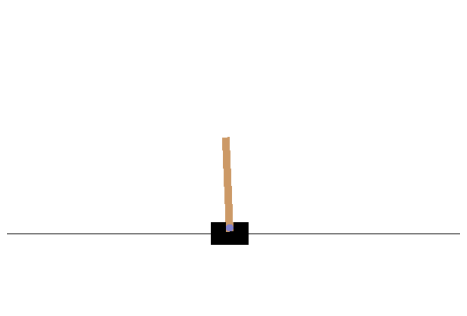

In [ ]:
# 実行結果の表示
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

## 課題